In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import time
import datetime
import tensorflow as tf
from pandas import read_csv
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

from sklearn.metrics import mean_squared_error, r2_score

from pandas import read_csv
from datetime import datetime
from math import sqrt
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras import optimizers

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

import chart_studio.plotly as py
import cufflinks as cf 
cf.go_offline(connected=True)

import seaborn as sns    
import matplotlib as mpl
import matplotlib.font_manager as fm

# 데이터 전처리

In [2]:
# 데이터 폴더 경로
path = './data/'

table = pd.DataFrame()

arrs = os.listdir(path)

fnames = []
for arr in arrs:
    fnames.append(arr)
    
# 데이터 가져오기
for i in range(len(fnames)): 
    data = pd.read_excel(path+fnames[i], skiprows=2)
    table = table.append(data)

rawdata = table.copy()
rawdata = rawdata[['년/월', '용존산소(㎎/L)', 'BOD(㎎/L)', 'COD(㎎/L)', '부유물질(㎎/L)' ]]
rawdata.rename(columns = {'년/월':'date', '용존산소(㎎/L)':'DO', 'BOD(㎎/L)':'BOD', 'COD(㎎/L)':'COD', '부유물질(㎎/L)':'SS'}, inplace = True)
rawdata.reset_index(inplace=True)
del rawdata['index']

dates= []
year = []
mon = []

for i in range(len(rawdata)):
    dates.append(str(rawdata['date'][i])[:-3])
    
rawdata['dates'] = dates

for i in range(len(rawdata)):
    year.append(str(rawdata['dates'][i])[:4])

for i in range(len(rawdata)):
    mon.append(str(rawdata['dates'][i])[5:])
    
rawdata['year'] = year
rawdata['month'] = mon



df = rawdata.copy()
df = df[['year', 'month','dates', 'DO', 'BOD', 'COD','SS']]
df.dropna(axis=0, inplace=True)

# 데이터 분할

In [3]:
df.index = pd.to_datetime(list(df['dates'])).strftime('%Y-%m')

train_set_size = 270

raw_train = df[:train_set_size]
raw_test = df[train_set_size:]

train_cols = ['DO', 'BOD', 'COD','SS']
test_cols = ['DO']

# train 셋, test 셋
x_train = raw_train.loc[:, train_cols].values
y_train = raw_train.loc[:, test_cols].values

x_test = raw_test.loc[:, train_cols].values
y_test = raw_test.loc[:, test_cols].values


#정규화
min_max_scaler = MinMaxScaler()
min_max_scaler_label = MinMaxScaler()

x_train_scaled = min_max_scaler.fit_transform(x_train)
y_train_scaled = min_max_scaler_label.fit_transform(y_train)

x_test_scaled = min_max_scaler.transform(x_test)
y_test_scaled = min_max_scaler_label.transform(y_test)

In [4]:
# 데이터를 시계열로 변환
def build_timeseries(mat, time_steps):
    dim_0 = mat.shape[0] - time_steps #데이터의 길이(레코드 수) - time_steps
    dim_1 = mat.shape[1] #컬럼 수 
    
    x = np.zeros((dim_0, time_steps, dim_1)) #dim_0개의 time_steps x dim_1 인 0행렬을 생성
    y = np.zeros((dim_0,)) #길이가 dim_0이고 값은 0인 배열 생성

    for i in range(dim_0):
        x[i] = mat[i:time_steps + i] # 데이터 셋을0~0+time_steps, 1~1+time_steps ... 로 분할
        y[i] = mat[time_steps + i, 0] # 데이터 셋의 배열 0번째 컬럼 값 (수온)
        
    print("length of time-series i/o", x.shape, y.shape)
    return x, y

In [5]:
x_train_scaled_time, y_train_scaled_time = build_timeseries(x_train_scaled, 1)
x_test_scaled_time, y_test_scaled_time = build_timeseries(x_test_scaled, 1)

length of time-series i/o (269, 1, 4) (269,)
length of time-series i/o (25, 1, 4) (25,)


In [6]:
from keras.layers import Dense, Activation, Flatten

In [7]:
def create_model(input_data):
    lstm_model = Sequential()
    lstm_model.add(Bidirectional(LSTM(100, return_sequences = True),  input_shape=(x_train_scaled_time.shape[1], x_train_scaled_time.shape[2])))
    lstm_model.add(Dense(4))
    lstm_model.add(Flatten())
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mse', optimizer='adam')
    
    return lstm_model

In [8]:
lstm_model = create_model(x_train_scaled_time)

In [9]:
lstm_model.summary() #모델 요약 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 200)            84000     
_________________________________________________________________
dense (Dense)                (None, 1, 4)              804       
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 84,809
Trainable params: 84,809
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = lstm_model.fit(x_train_scaled_time, y_train_scaled_time, epochs=10, verbose=1, batch_size=32, shuffle=False, validation_split=0.2)

Epoch 1/10
7/7 [==============================] - 2s 97ms/step - loss: 0.2707 - val_loss: 0.1877
Epoch 2/10
7/7 [==============================] - 0s 16ms/step - loss: 0.1321 - val_loss: 0.0806
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0554 - val_loss: 0.0368
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0323 - val_loss: 0.0334
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0338 - val_loss: 0.0332
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0314 - val_loss: 0.0316
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0279 - val_loss: 0.0334
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0276 - val_loss: 0.0343
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0273 - val_loss: 0.0330
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0313


In [11]:
y_predicted = lstm_model.predict(x_test_scaled_time) # 모델의 출력 예측 
y_predicted_value = min_max_scaler_label.inverse_transform(y_predicted) #본래 값으로 돌리기
y_test_value = min_max_scaler_label.inverse_transform(y_test_scaled_time.reshape(-1, 1)) #

In [12]:
# 실제 데이터와 예측 데이터 비교하는 데이터프레임
compare_data_new = pd.DataFrame()
compare_data_new['Actual Temperature'] = y_test_value.flatten()
compare_data_new['Predicted Temperature'] = np.round(y_predicted_value,1)
compare_data_new.head()

,Actual Temperature,Predicted Temperature
0,14.6,10.4
1,11.0,11.6
2,12.9,10.5
3,11.8,11.2
4,7.8,11.3


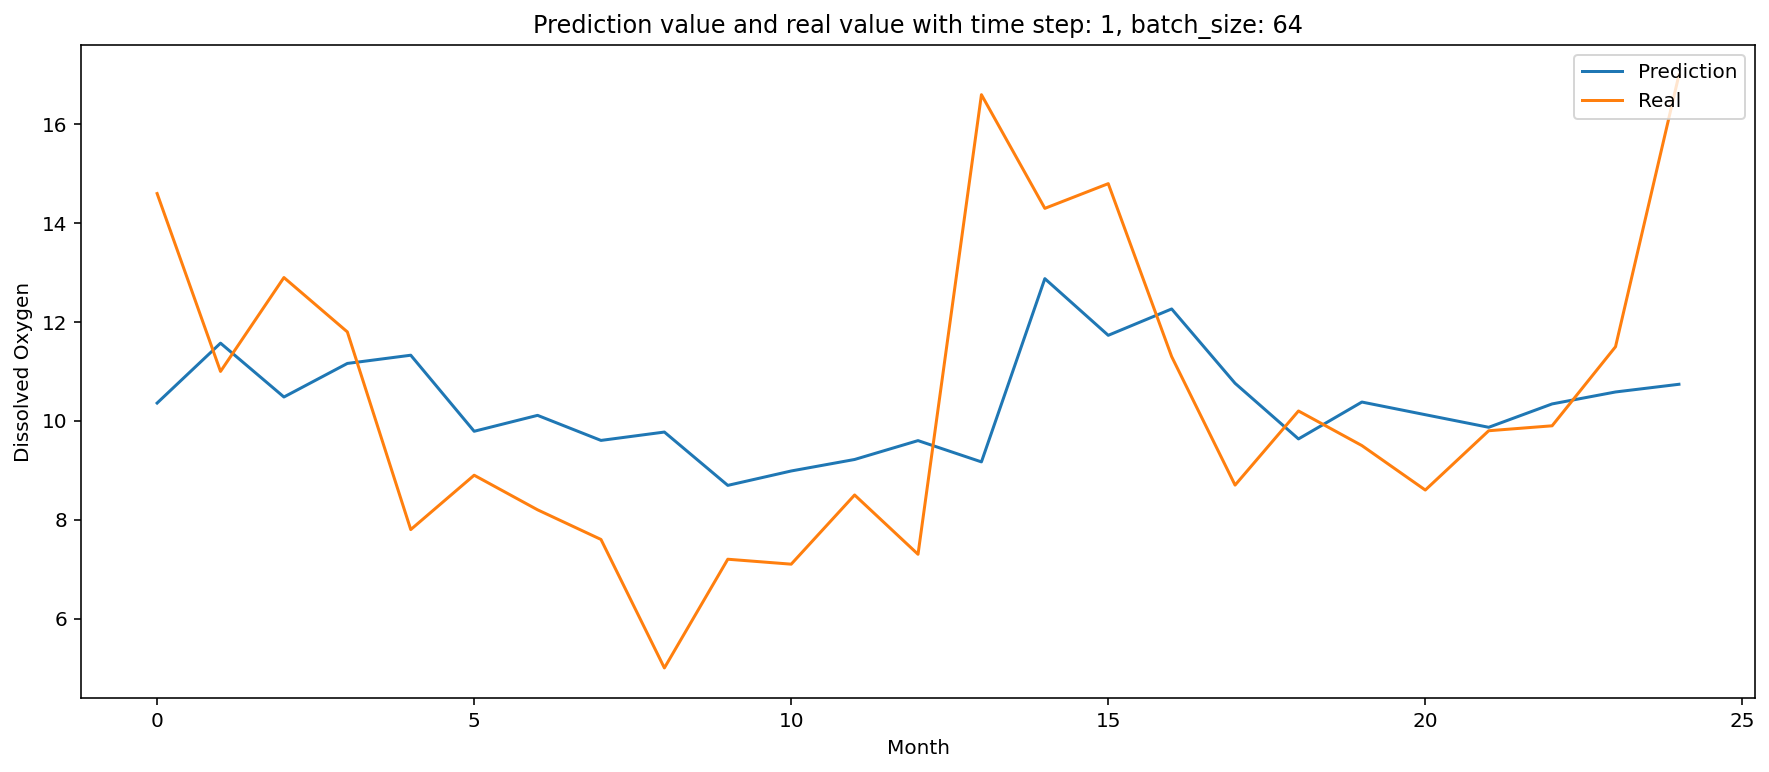

In [13]:
# 예측 값과 실제 값 비교 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_predicted_value)
plt.plot(y_test_value)
plt.title("Prediction value and real value with time step: %s, batch_size: %s" % (1, 64))
plt.ylabel('Dissolved Oxygen')
plt.xlabel("Month")
plt.legend(['Prediction', 'Real'], loc='upper right')

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=compare_data_new.index, y=compare_data_new['Actual Temperature'],mode='lines',name='실측치'))
fig.add_trace(go.Scatter(x=compare_data_new.index, y=compare_data_new['Predicted Temperature'],mode='lines',name='예측치'))

fig.update_layout(
    title_text="송파구 잠실동 한강의 용존 산소량 실측치, 예측치 그래프",
    title_x=0.5,
    xaxis=dict(title='월'),
    yaxis=dict({'categoryorder':'total descending'},
               title='용존 산소량'
              ),
    font=dict(
        family="Noto Sans KR",
        size=14,
    )
)

fig.show()

In [15]:
fig.write_image("/home/datastory/no_18.(신규)한강의 용존 산소량을 통한 수질 예측/18/img_5_1.png")
                
line_json = fig.to_json()
line_json
json_obj = json.loads(line_json, encoding="utf-8")
json_obj_d = json.dumps(json_obj, ensure_ascii=False)

json_obj_d
                
with open('./18/img_5_1.json', 'w', encoding='utf-8') as make_file:
    json.dump(json_obj, make_file, indent="\t", ensure_ascii=False)

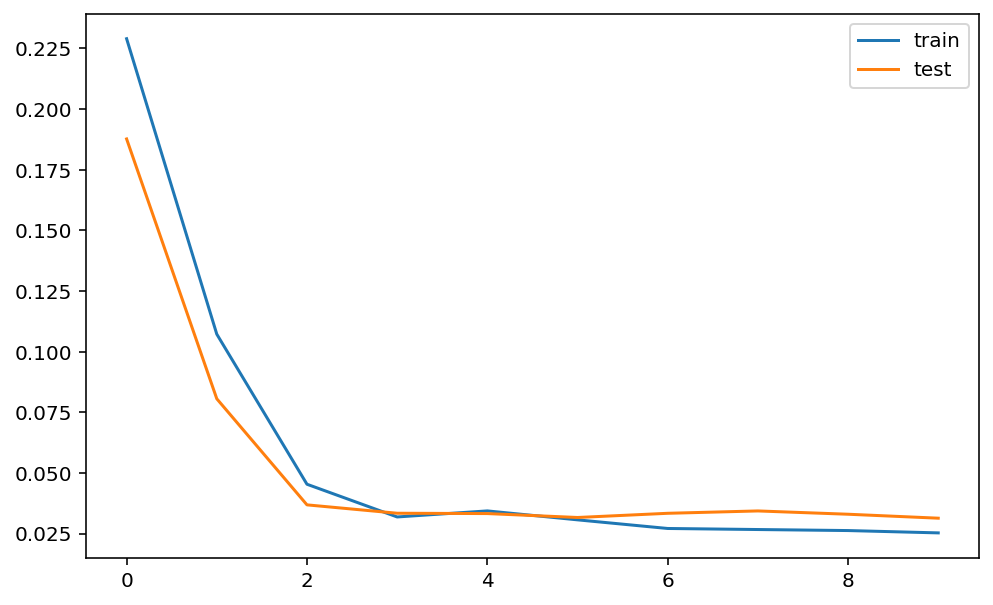

In [16]:
#loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(loc='upper right')

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['loss'],mode='lines',name='훈련'))
fig.add_trace(go.Scatter(y=history.history['val_loss'],mode='lines',name='테스트'))

fig.update_layout(
    title_text="송파구 잠실동 한강의 월별 용존 산소량의 검증 손실 그래프",
    title_x=0.5,
    xaxis=dict(title='학습 횟수'),
    yaxis=dict({'categoryorder':'total descending'},
               title='손실값'
              ),
    font=dict(
        family="Noto Sans KR",
        size=14,
    )
)

fig.show()


In [24]:
fig.write_image("/home/datastory/no_18.(신규)한강의 용존 산소량을 통한 수질 예측/18/img_6_1.png")
                
line_json = fig.to_json()
line_json
json_obj = json.loads(line_json, encoding="utf-8")
json_obj_d = json.dumps(json_obj, ensure_ascii=False)

json_obj_d
                
with open('./18/img_6_1.json', 'w', encoding='utf-8') as make_file:
    json.dump(json_obj, make_file, indent="\t", ensure_ascii=False)

In [25]:
#mape
def mean_absolute_percentage_error(y_test, y_pred):
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [26]:
#rmse
def rmse_r(y, y_pred):
    return mean_squared_error(y, y_pred) ** 0.5

In [27]:
mape = mean_absolute_percentage_error(y_test_value, y_predicted_value)
rmse = rmse_r(y_test_value, y_predicted_value)

In [28]:
print("mape :", mape)
print("rsme :", rmse)

mape : 21.448725291731783
rsme : 2.795136993898646
